In [1]:
from pathlib import Path
from omnibelt import toposort, load_json, save_json
from itertools import product, combinations
# import pyperclip
import random
import json
from PIL import Image
from graphviz import Digraph
import matplotlib.pyplot as plt
import io
# import clipboard
import networkx as nx
from tqdm.notebook import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
from omniply import tool, ToolKit, Context

import numpy as np
import torch
from causalbenchmark.novo.simulation.models import Bernoulli, ConditionalBernoulli, BernoulliNetwork
from causalbenchmark.novo.seeding import NewsHeadlines, StatisticsPrompting, Story
# from causalbenchmark.novo.seeding.prompting import GraphInfo
from causalbenchmark.novo.templating import FixedTemplate, SimpleTemplater, FileTemplate
from causalbenchmark.novo import misc

In [2]:
spark_generator = NewsHeadlines(#locs=['jp'], #['gb', 'de', 'fr', 'it', 'nl'], 
                                dataset_root=Path(r'/home/fleeb/workspace/local_data/nnn/babel-briefings-v1'),
                                # dataset_root=Path(r'C:\Users\anwan\Documents\workspace\nnn\babel-briefings-v1'),
                                # dataset_root=Path(r'C:\Users\anwan\workspace\local_data\nnn\babel-briefings-v1'),
    cats = ['business'],
    # business, entertainment, general, health, science, sports, technology
                                ).load(pbar=tqdm)
len(spark_generator.article_IDs)

  0%|          | 0/54 [00:00<?, ?it/s]

In [331]:
# ctx = Story(story_root=misc.data_root() / 'stories', story_id='Digital Transformation at Khalifa Port: Data-Driven Insights')
ctx = Story(story_root=misc.data_root() / 'stories').populate_defaults()
ctx.include(spark_generator,)
# print(ctx)
# ctx['seed'] = 2679163#2494534#91220#1684065#6805333
print(ctx['seed'])
print(ctx['spark'])

7072424
Title: Electra Consumer Products enters the hot field of solar energy - Globes
Description: The company announced that it signed a partnership agreement with SolarEdge in Israel • At the same time it acquired control of a company that operates in the field of solar panels in Israel • According to the company's statement, its activity turnover in the field will amount to approximately NIS 400 million within three years
Original Language: Hebrew


In [332]:
# if 'prompt_story' in ctx:
#     del ctx['prompt_motivation']
print(ctx['prompt_motivation'])

We have a news article headline, and we would like to identify a potential specific analysis that could be motivated by the article. Importantly, we would like specific details to be mentioned in the setting, even if they don't show up in the original article, to paint a vivid picture of the motivation and potential features of the data.

Here is the article headline:

```
Title: Electra Consumer Products enters the hot field of solar energy - Globes
Description: The company announced that it signed a partnership agreement with SolarEdge in Israel • At the same time it acquired control of a company that operates in the field of solar panels in Israel • According to the company's statement, its activity turnover in the field will amount to approximately NIS 400 million within three years
Original Language: Hebrew
```

Write a 2-3 sentence introduction to a statistical analysis that could be motivated by this article. Be sure to include specific details about the data that would be used 

In [333]:
##############################################
motivation_raw = '''
{
  "introduction": "With Electra Consumer Products stepping into the solar energy sector through a partnership with SolarEdge and acquiring a solar panel company in Israel, it's intriguing to consider the impact of these moves on their financial growth. By examining Electra's annual sales records, especially focusing on the revenue generated from solar energy products, we can gauge the success of their new venture. Comparing these figures over the next three years against their projected NIS 400 million turnover will provide a clear picture of how effective this strategic shift has been for Electra.",
  "title": "Electra_SolarEnergyVenture_ImpactAnalysis"
}

'''
##############################################
ctx['motivation'] = json.loads(motivation_raw)

In [334]:
# if 'prompt_graph' in ctx:
#     del ctx['prompt_graph']
# print(FileTemplate('graph').fill_in(ctx))
print(ctx['prompt_graph'])

We are interested in building a causal model based on the explicit and implicit assumptions contained in the specified article and then using causal inference to evaluate the reasoning. Answer the following questions to design an interesting, simple, and most importantly realistic causal model from a news article.

To help understand the instructions here are some tips:
- all variables are always binary and (at least in principle) measurable, so when creating and selecting variables, make sure it is reasonable to treat them as binary
- whenever you propose a variable, make sure to define the meaning of each value it can take, and mention whether it is observable or not
- outcome variables are always observable, and should always have 2-3 causal parents (including treatment, mediator, and confounder variables)
- treatment variables are always observable and intervenable, that means it must be possible to (at least in principle) change their value if desired, and these should generally h

In [335]:
# nodes = ctx['nodes']
#################################################
nodes_raw = '''
[
  {
    "name": "Financial Success of Electra's Solar Venture",
    "description": "Whether Electra's venture into solar energy is financially successful",
    "type": "outcome",
    "observed": true,
    "values": ["Not successful", "Successful"],
    "parents": ["Market Demand for Solar Energy", "Public Perception of Electra as a Green Company"]
  },
  {
    "name": "Electra's Partnership with SolarEdge",
    "description": "Electra's partnership agreement with SolarEdge",
    "type": "treatment",
    "observed": true,
    "values": ["No partnership", "Partnership established"],
    "parents": ["Market Demand for Solar Energy", "Government Incentives for Renewable Energy"]
  },
  {
    "name": "Acquisition of Solar Panel Company",
    "description": "Electra's acquisition of a solar panel company in Israel",
    "type": "treatment",
    "observed": true,
    "values": ["No acquisition", "Acquisition made"],
    "parents": []
  },
  {
    "name": "Market Demand for Solar Energy",
    "description": "The market demand for solar energy products",
    "type": "confounder",
    "observed": true,
    "values": ["Low demand", "High demand"],
    "parents": []
  },
  {
    "name": "Government Incentives for Renewable Energy",
    "description": "Government incentives for renewable energy in Israel",
    "type": "confounder",
    "observed": true,
    "values": ["No incentives", "Incentives present"],
    "parents": []
  },
  {
    "name": "Increase in Electra's Solar Product Range",
    "description": "Expansion of Electra's range of solar energy products",
    "type": "mediator",
    "observed": true,
    "values": ["No increase", "Increase in range"],
    "parents": ["Electra's Partnership with SolarEdge", "Acquisition of Solar Panel Company"]
  },
  {
    "name": "Public Perception of Electra as a Green Company",
    "description": "Public perception of Electra as a company invested in green energy",
    "type": "mediator",
    "observed": true,
    "values": ["Not perceived as green", "Perceived as green"],
    "parents": ["Increase in Electra's Solar Product Range"]
  },
  {
    "name": "Electra's Overall Market Reputation",
    "description": "Overall market reputation of Electra",
    "type": "collider",
    "observed": true,
    "values": ["Poor reputation", "Good reputation"],
    "parents": ["Electra's Partnership with SolarEdge", "Financial Success of Electra's Solar Venture"]
  }
]

'''
#################################################
if len(nodes_raw):
    nodes = json.loads(nodes_raw)
varparents = {node['name']: node['parents'] for node in nodes}
varorder = toposort(varparents)
nodes = sorted(nodes, key=lambda x: varorder.index(x['name']))
nodes = [node for node in nodes if len(node['parents']) or any(node['name'] in parent for parent in varparents.values())]
ctx['nodes'] = nodes

ValueError: Could not save to JPEG for display

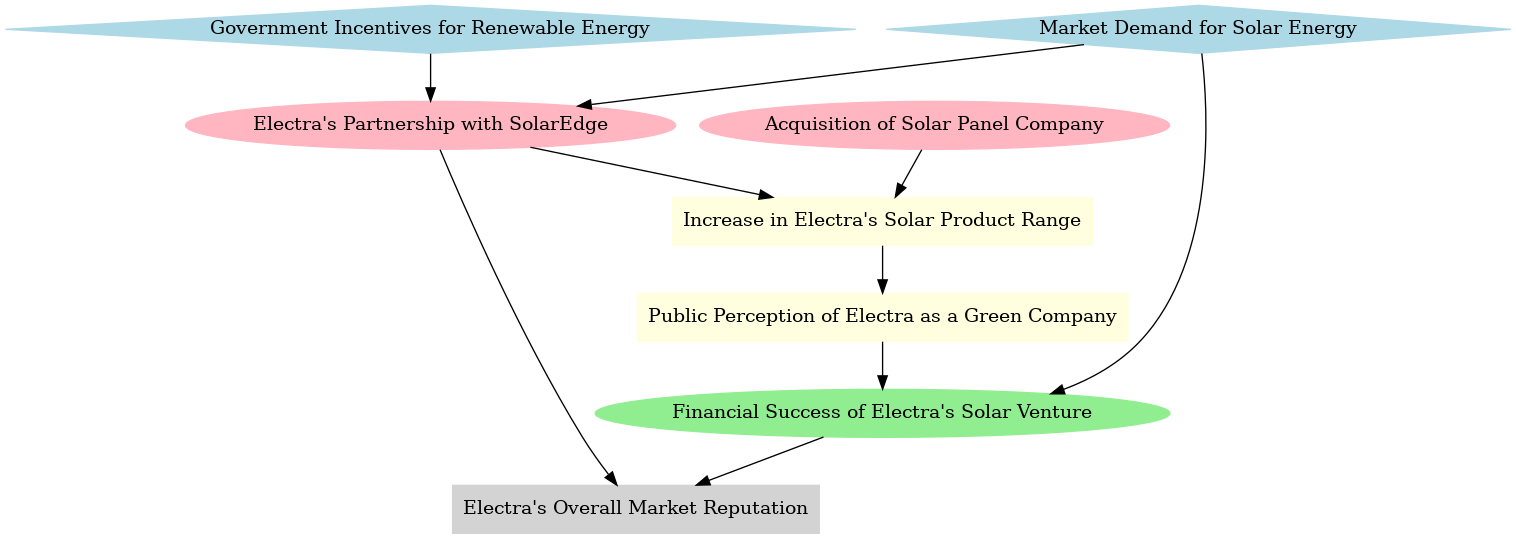

In [336]:
dot = Digraph(comment='Causal Model')
node_styles = {
    "treatment": {"shape": "ellipse", "style": "filled", "color": "lightpink"},
    "outcome": {"shape": "ellipse", "style": "filled", "color": "lightgreen"},
    "confounder": {"shape": "diamond", "style": "filled", "color": "lightblue"},
    "mediator": {"shape": "box", "style": "filled", "color": "lightyellow"},
    "collider": {"shape": "box", "style": "filled", "color": "lightgray"}
}
for node in ctx['nodes']:
    style = node_styles.get(node["type"], {"shape": "ellipse"})
    dot.node(node["name"], node["name"], **style)
for node in ctx['nodes']:
    for parent in node["parents"]:
        dot.edge(parent, node["name"])
# dot.view()
dot.render(str(misc.temp_root() / 'graph'), format='png')
Image.open(misc.temp_root() / 'graph.png')

In [337]:
# if 'prompt_story' in ctx:
#     del ctx['prompt_motivation']
# print(FileTemplate('structure').fill_in(ctx))
print(ctx['prompt_structure'])


We have a causal bayes net model for an analysis about this topic:

With Electra Consumer Products stepping into the solar energy sector through a partnership with SolarEdge and acquiring a solar panel company in Israel, it's intriguing to consider the impact of these moves on their financial growth. By examining Electra's annual sales records, especially focusing on the revenue generated from solar energy products, we can gauge the success of their new venture. Comparing these figures over the next three years against their projected NIS 400 million turnover will provide a clear picture of how effective this strategic shift has been for Electra.

Write a list of 4-8 concise and well-worded sentences that describe the structure and associated assumptions of the causal graph. The sentences should be ordered from describing the most noteworthy/surprising features of the graph to the most natural/intuitive features. Use an intuitive conversational style to describe the causal graph, and 

In [338]:
#################################################

structure_raw = '''
[
    {"sentence": "The public's perception of Electra as a green energy company is influenced solely by how much they expand their solar product range, showcasing a direct link between the company's product decisions and their green image.", "involved": ["Public Perception of Electra as a Green Company", "Increase in Electra's Solar Product Range"]},
    {"sentence": "Interestingly, the overall market reputation of Electra depends on both their financial success in the solar venture and their partnership with SolarEdge, highlighting a blend of financial performance and strategic alliances in shaping company reputation.", "involved": ["Electra's Overall Market Reputation", "Financial Success of Electra's Solar Venture", "Electra's Partnership with SolarEdge"]},
    {"sentence": "Electra's decision to partner with SolarEdge is influenced by the broader market demand for solar energy and government incentives, suggesting external factors play a significant role in shaping company strategy.", "involved": ["Electra's Partnership with SolarEdge", "Market Demand for Solar Energy", "Government Incentives for Renewable Energy"]},
    {"sentence": "The financial success of Electra's venture into solar energy is not only dependent on the market demand for solar energy but is also tied to how the public perceives them as a green company, indicating a complex interaction between market forces and brand image.", "involved": ["Financial Success of Electra's Solar Venture", "Market Demand for Solar Energy", "Public Perception of Electra as a Green Company"]},
    {"sentence": "Electra's range of solar products is expected to grow following either their acquisition of a solar panel company or their partnership with SolarEdge, showing how both internal decisions and collaborations contribute to product expansion.", "involved": ["Increase in Electra's Solar Product Range", "Electra's Partnership with SolarEdge", "Acquisition of Solar Panel Company"]},
    {"sentence": "External factors like market demand and government incentives do not directly influence Electra's financial success or their decision to acquire a solar panel company, but they do shape the company's partnership choices.", "involved": ["Market Demand for Solar Energy", "Government Incentives for Renewable Energy", "Electra's Partnership with SolarEdge", "Financial Success of Electra's Solar Venture", "Acquisition of Solar Panel Company"]}
]

'''

#################################################
ctx['structure'] = json.loads(structure_raw)

In [339]:
# if 'prompt_stats' in ctx:
#     del ctx['descriptions']
#     del ctx['prob_questions']
#     del ctx['prompt_stats']
# print(FileTemplate('stats').fill_in(ctx))
print(ctx['prompt_stats'])

We have a causal bayes net based on the following topic:

With Electra Consumer Products stepping into the solar energy sector through a partnership with SolarEdge and acquiring a solar panel company in Israel, it's intriguing to consider the impact of these moves on their financial growth. By examining Electra's annual sales records, especially focusing on the revenue generated from solar energy products, we can gauge the success of their new venture. Comparing these figures over the next three years against their projected NIS 400 million turnover will provide a clear picture of how effective this strategic shift has been for Electra.

Now we would like to estimate the probabilities of certain events in a corresponding causal bayes net.

Using commonsense, estimate the probabilities of the following events:

1. what is the probability that "Acquisition of Solar Panel Company" is "Acquisition made" (rather than "No acquisition")?
2. what is the probability that "Market Demand for Sola

In [340]:
# probabilities = ctx['stats']
#################################################

probabilities_raw = '''
{
  "1": [0.8, 0.9],
  "2": [0.7, 0.8],
  "3": [0.6, 0.7],
  "4": [0.2, 0.3],
  "5": [0.4, 0.5],
  "6": [0.5, 0.6],
  "7": [0.7, 0.8],
  "8": [0.1, 0.2],
  "9": [0.7, 0.8],
  "10": [0.6, 0.7],
  "11": [0.9, 1.0],
  "12": [0.1, 0.2],
  "13": [0.6, 0.7],
  "14": [0.2, 0.3],
  "15": [0.4, 0.5],
  "16": [0.5, 0.6],
  "17": [0.8, 0.9],
  "18": [0.3, 0.4],
  "19": [0.5, 0.6],
  "20": [0.4, 0.5],
  "21": [0.7, 0.8]
}

'''

#################################################
ctx['stats'] = json.loads(probabilities_raw)

In [341]:
raw_prob_samples = []
def to_prob_range(raw):
    raw = [prange for _, prange in sorted(raw.items(), key=lambda item: int(item[0]))]
    return torch.tensor(raw)

prob_ranges = to_prob_range(ctx['stats'])
lower_bound, upper_bound = prob_ranges.t()

net = BernoulliNetwork({node['name']: node['parents'] for node in ctx['nodes']})

def mc_samples(N, *fns):
    estimates = []
    for _ in tqdm(range(N)):
        param_sample = torch.rand(len(prob_ranges)) * (upper_bound - lower_bound) + lower_bound
        net.set_params(param_sample)
        estimates.append([fn() for fn in fns])
    return torch.tensor(estimates)
def make_ate_fn(treatment, outcome, conditions=None):
    def ate_fn():
        return net.ate(treatment, outcome, conditions=conditions).item()
    return ate_fn
def make_corr_fn(v1, v2):
    def corr_fn():
        return net.correlation(v1, v2).item()
    return corr_fn
treatment1, treatment2 = [n for n in ctx['treatments']]
# t1vals = [node['values'] for node in ctx['nodes'] if node['name'] == treatment1][0]
# t2vals = [node['values'] for node in ctx['nodes'] if node['name'] == treatment2][0]
outcome = ctx['outcome']#['name']
# ovals = [node['values'] for node in ctx['nodes'] if node['name'] == outcome][0]
confounders = [node for node in ctx['confounders']]

print(tabulate([
    [treatment1['name'], *treatment1['values'], treatment1['description']],
    [treatment2['name'], *treatment2['values'], treatment2['description']],
    [outcome['name'], *outcome['values'], outcome['description']],
]))

cate_keys = [(treatment, confounder, cval) for treatment in ctx['treatments'] for confounder in ctx['confounders'] for cval in [0, 1]]
cate_fns = [make_ate_fn(treatment['name'], outcome['name'], conditions={confounder['name']: val}) for treatment, confounder, val in cate_keys]
ate1, ate2, corr1, corr2, *cates = mc_samples(20, make_ate_fn(treatment1['name'], outcome['name']), make_ate_fn(treatment2['name'], outcome['name']),
                                      make_corr_fn(treatment1['name'], outcome['name']), make_corr_fn(treatment2['name'], outcome['name']), *cate_fns).t()

print('\n'.join(f'{node["name"]!r} means {node["description"]}' for node in ctx['nodes']))
print(tabulate([
    [f'{treatment1["values"][1]}', f'{treatment1["name"]}', f'{outcome["values"][1]}', f'{outcome["name"]}', ate1.mean(), corr1.mean(), ],
    [f'{treatment2["values"][1]}', f'{treatment2["name"]}', f'{outcome["values"][1]}', f'{outcome["name"]}', ate2.mean(), corr2.mean(), ],
], headers=['Treatment Value', 'Treatment', 'Outcome Value', 'Outcome', 'ATE', 'Correlation']))

--------------------------------------------  --------------  -----------------------  ---------------------------------------------------------------------
Acquisition of Solar Panel Company            No acquisition  Acquisition made         Electra's acquisition of a solar panel company in Israel
Electra's Partnership with SolarEdge          No partnership  Partnership established  Electra's partnership agreement with SolarEdge
Financial Success of Electra's Solar Venture  Not successful  Successful               Whether Electra's venture into solar energy is financially successful
--------------------------------------------  --------------  -----------------------  ---------------------------------------------------------------------


  0%|          | 0/20 [00:00<?, ?it/s]

/home/fleeb/miniconda3/lib/python3.11/site-packages/torch/masked/maskedtensor/core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  warnings.warn(("The PyTorch API of MaskedTensors is in prototype stage "


'Acquisition of Solar Panel Company' means Electra's acquisition of a solar panel company in Israel
'Market Demand for Solar Energy' means The market demand for solar energy products
'Government Incentives for Renewable Energy' means Government incentives for renewable energy in Israel
"Electra's Partnership with SolarEdge" means Electra's partnership agreement with SolarEdge
"Increase in Electra's Solar Product Range" means Expansion of Electra's range of solar energy products
'Public Perception of Electra as a Green Company' means Public perception of Electra as a company invested in green energy
"Financial Success of Electra's Solar Venture" means Whether Electra's venture into solar energy is financially successful
"Electra's Overall Market Reputation" means Overall market reputation of Electra
Treatment Value          Treatment                             Outcome Value    Outcome                                             ATE    Correlation
-----------------------  --------------

/home/fleeb/miniconda3/lib/python3.11/site-packages/torch/masked/maskedtensor/core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  warnings.warn(("The PyTorch API of MaskedTensors is in prototype stage "


Treatment                                                             ATE    Correlation  Outcome
------------------------------------------------------------------  -----  -------------  ------------------------------------------------------------------
Acquisition made Acquisition of Solar Panel Company                  0              0     High demand Market Demand for Solar Energy
Acquisition made Acquisition of Solar Panel Company                  0              0     Incentives present Government Incentives for Renewable Energy
Acquisition made Acquisition of Solar Panel Company                  0              0     Partnership established Electra's Partnership with SolarEdge
Acquisition made Acquisition of Solar Panel Company                  0.39           0.39  Increase in range Increase in Electra's Solar Product Range
Acquisition made Acquisition of Solar Panel Company                  0.18           0.13  Perceived as green Public Perception of Electra as a Green Company
Ac

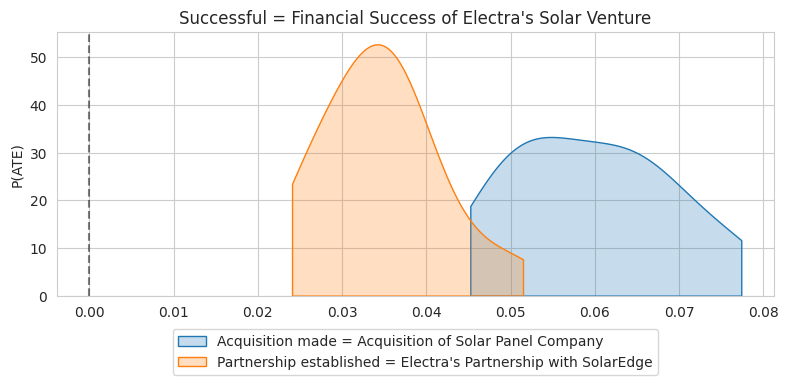

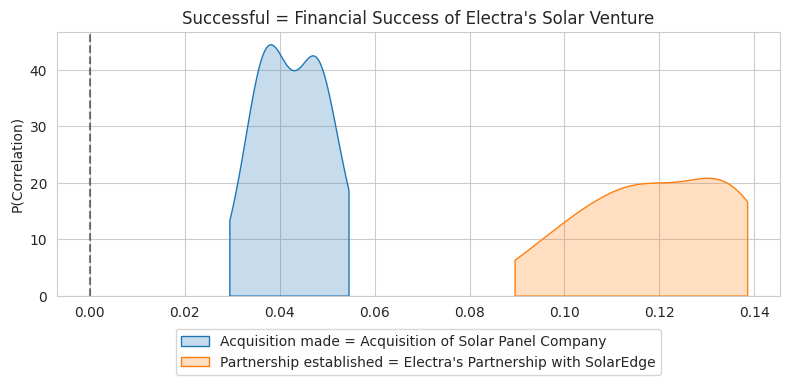

In [342]:
plt.figure(figsize=(8, 4))
sns.kdeplot(ate1, label=f'{treatment1["values"][1]} = {treatment1["name"]}', fill=True, clip=(min(ate1), max(ate1)));
sns.kdeplot(ate2, label=f'{treatment2["values"][1]} = {treatment2["name"]}', fill=True, clip=(min(ate2), max(ate2)));
plt.title(f'{outcome["values"][1]} = {outcome["name"]}')
plt.ylabel(f'P(ATE)')
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -.1))
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
# plt.xlim(-1, 1)
plt.tight_layout();

plt.figure(figsize=(8, 4))
sns.kdeplot(corr1, label=f'{treatment1["values"][1]} = {treatment1["name"]}', fill=True, clip=(min(corr1), max(corr1)));
sns.kdeplot(corr2, label=f'{treatment2["values"][1]} = {treatment2["name"]}', fill=True, clip=(min(corr2), max(corr2)));
plt.title(f'{outcome["values"][1]} = {outcome["name"]}')
plt.ylabel(f'P(Correlation)')
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -.1))
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
# plt.xlim(-1, 1)
plt.tight_layout();

mn1, mx1 = ate1.min().item(), ate1.max().item()
mu1 = ate1.mean().item()
# assert mn1 * mx1 > 0, f'{mn1} * {mx1} < 0'
mn2, mx2 = ate2.min().item(), ate2.max().item()
mu2 = ate2.mean().item()
# assert mn2 * mx2 > 0, f'{mn2} * {mx2} < 0'
ctx['ate1'] = ate1.mean().item()
ctx['ate2'] = ate2.mean().item()
reverse1 = mu1 < 0
reverse2 = mu2 < 0
# print(tabulate([(node['name'], *node['values'], node['description']) for node in ctx['nodes']], headers=['Variable Name', 'Value 0', 'Value 1', 'Description']))
# outcome = [node['name'] for node in ctx['nodes'] if node['type'] == 'outcome'][0]
tbl = []

for node1, node2 in product(ctx['nodes'], ctx['nodes']):
    if node1 != node2:
        tbl.append([
                    f'{node1["values"][1]} {node1["name"]}', 
                    f"{net.ate(node1['name'], node2['name']).item():.2f}", 
                    f"{net.correlation(node1['name'], node2['name']).item():.2f}",
                    f'{node2["values"][1]} {node2["name"]}', 
                    # node1['description'], 
                    # node2['description'], 
                    ])
print(tabulate(tbl, headers=['Treatment', 'ATE', 'Correlation', 'Outcome', 
                             # 'Treatment Description', 'Outcome Description'
                             ]))

# print(net.backdoor_estimand(treatment1['name'], outcome['name']))
# print(net.backdoor_estimand(treatment2['name'], outcome['name']))

In [343]:
# if 'prompt_verbs' in ctx:
#     del ctx['prompt_verbs']
print(FileTemplate('verbs').fill_in(ctx))
# print(ctx['prompt_verbs'])

We would like to find very natural verbalizations of the following binary variables selected from a statistical model. The verbalizations should sound more natural and organic, so that you could imagine them being used in a newspaper article or casual conversation, while still being semantically equivalent to the variable and value definition.

Here are the templates that we use to verbalize the variables:

1. One of the variables is {descriptor}.
2. {subject} [often/usually/sometimes/rarely/etc.] {predicate#}. (with pronoun: {pronoun})
3. There is a [number]% chance that {nounclause#}.
4. {preposition} [number]% of {domain}, {subclause#}.
5. Conditional sentence: {condition#}, [some consequence].
6. Interventional: If {action#}, [some effect].

Variable 'Acquisition of Solar Panel Company' (0='No acquisition', 1='Acquisition made') means Electra's acquisition of a solar panel company in Israel
Variable 'Market Demand for Solar Energy' (0='Low demand', 1='High demand') means The market

In [344]:
# verbalization = ctx['verbs']
#################################################
verbalization_raw = '''
{
  "Acquisition of Solar Panel Company": {
    "descriptor": ["the acquisition of a solar panel company", "Electra's expansion into solar panel operations"],
    "subject": "Electra",
    "predicate0": ["has not acquired a solar panel company", "remains independent of solar panel company ownership"],
    "predicate1": ["has acquired a solar panel company", "expanded its operations to include a solar panel company"],
    "pronoun": "it",
    "nounclause0": ["Electra has not acquired a solar panel company", "Electra remains independent of solar panel company ownership"],
    "nounclause1": ["Electra has acquired a solar panel company", "Electra expanded its operations to include a solar panel company"],
    "preposition": ["in", "within"],
    "domain": "the industry",
    "subclause0": ["Electra has not made any acquisitions", "no solar panel company is part of Electra's business"],
    "subclause1": ["Electra has expanded its business through acquisition", "a solar panel company is now under Electra's wing"],
    "condition0": ["if Electra does not acquire a solar panel company", "without a solar panel company under its belt"],
    "condition1": ["if Electra acquires a solar panel company", "with a new solar panel company in its portfolio"],
    "action0": ["Electra refrains from acquiring a solar panel company", "Electra decides against solar panel company acquisition"],
    "action1": ["Electra goes ahead with a solar panel company acquisition", "Electra decides to acquire a solar panel company"]
  },
  "Market Demand for Solar Energy": {
    "descriptor": ["the market demand for solar energy", "public interest in solar energy products"],
    "subject": "consumers",
    "predicate0": ["are not heavily interested in solar energy", "show limited enthusiasm for solar energy"],
    "predicate1": ["are highly interested in solar energy", "demonstrate strong enthusiasm for solar energy"],
    "pronoun": "they",
    "nounclause0": ["there is a low demand for solar energy", "solar energy products are not in high demand"],
    "nounclause1": ["there is a high demand for solar energy", "solar energy products are in high demand"],
    "preposition": ["among", "within"],
    "domain": "the market",
    "subclause0": ["solar energy is not a top priority", "solar energy products don't see much demand"],
    "subclause1": ["solar energy is a sought-after commodity", "solar energy products are flying off the shelves"],
    "condition0": ["when demand for solar energy is low", "if solar energy products aren't in vogue"],
    "condition1": ["when demand for solar energy is high", "if solar energy products are trending"],
    "action0": ["consumer interest in solar energy drops", "the market shows less enthusiasm for solar products"],
    "action1": ["consumer interest in solar energy spikes", "the market shows heightened enthusiasm for solar products"]
  },
  "Government Incentives for Renewable Energy": {
    "descriptor": ["government incentives for renewable energy", "state support for green energy initiatives"],
    "subject": "the government",
    "predicate0": ["is not offering incentives for renewable energy", "has withheld incentives for green energy"],
    "predicate1": ["is offering incentives for renewable energy", "supports green energy with incentives"],
    "pronoun": "it",
    "nounclause0": ["there are no government incentives for renewable energy", "renewable energy lacks state incentives"],
    "nounclause1": ["government incentives for renewable energy are available", "renewable energy is supported by state incentives"],
    "preposition": ["in", "under"],
    "domain": "the policy",
    "subclause0": ["renewable energy is not backed by government incentives", "state support for green energy is absent"],
    "subclause1": ["renewable energy benefits from government incentives", "state support boosts green energy initiatives"],
    "condition0": ["if there are no government incentives", "without state incentives for renewable energy"],
    "condition1": ["if government incentives are present", "with state incentives boosting renewable energy"],
    "action0": ["the government pulls back on renewable energy incentives", "state support for green energy is withdrawn"],
    "action1": ["the government introduces incentives for renewable energy", "state support for green energy is enhanced"]
  },
  "Electra's Partnership with SolarEdge": {
    "descriptor": ["Electra's partnership with SolarEdge", "the collaborative venture between Electra and SolarEdge"],
    "subject": "Electra",
    "predicate0": ["has not partnered with SolarEdge", "remains independent from SolarEdge"],
    "predicate1": ["has established a partnership with SolarEdge", "joined forces with SolarEdge"],
    "pronoun": "it",
    "nounclause0": ["Electra and SolarEdge are not in a partnership", "there is no collaboration between Electra and SolarEdge"],
    "nounclause1": ["Electra and SolarEdge have formed a partnership", "a collaborative venture exists between Electra and SolarEdge"],
    "preposition": ["in", "within"],
    "domain": "the sector",
    "subclause0": ["Electra operates independently of SolarEdge", "no joint venture is pursued with SolarEdge"],
    "subclause1": ["Electra collaborates closely with SolarEdge", "a joint venture is formed with SolarEdge"],
    "condition0": ["if Electra does not partner with SolarEdge", "without a partnership with SolarEdge"],
    "condition1": ["if Electra partners with SolarEdge", "with a strategic alliance with SolarEdge"],
    "action0": ["Electra decides against partnering with SolarEdge", "Electra stays away from a joint venture with SolarEdge"],
    "action1": ["Electra opts for a partnership with SolarEdge", "Electra enters into a joint venture with SolarEdge"]
  },
  "Increase in Electra's Solar Product Range": {
    "descriptor": ["the expansion of Electra's solar product range", "the diversification of Electra's solar offerings"],
    "subject": "Electra",
    "predicate0": ["has not expanded its solar product range", "keeps a limited range of solar products"],
    "predicate1": ["has significantly expanded its solar product range", "offers a wider variety of solar products"],
    "pronoun": "it",
    "nounclause0": ["Electra's range of solar products remains unchanged", "there is no increase in Electra's solar offerings"],
    "nounclause1": ["Electra's range of solar products has grown", "there is a notable increase in Electra's solar offerings"],
    "preposition": ["in", "among"],
    "domain": "the lineup",
    "subclause0": ["Electra maintains a consistent line of solar products", "no new solar products are added by Electra"],
    "subclause1": ["Electra introduces new solar products", "Electra's solar product lineup grows extensively"],
    "condition0": ["if Electra does not expand its solar product range", "without new additions to Electra's solar products"],
    "condition1": ["if Electra expands its solar product range", "with a growing variety of solar products from Electra"],
    "action0": ["Electra refrains from adding new solar products", "Electra sticks to its existing solar product range"],
    "action1": ["Electra adds new solar products", "Electra diversifies its range of solar products"]
  },
  "Public Perception of Electra as a Green Company": {
    "descriptor": ["the public image of Electra as a green company", "how Electra is viewed in terms of environmental commitment"],
    "subject": "Electra",
    "predicate0": ["is not seen as a green company by the public", "lacks a green image in the public eye"],
    "predicate1": ["is perceived as a green company by the public", "enjoys a green reputation among consumers"],
    "pronoun": "it",
    "nounclause0": ["Electra is not recognized as environmentally friendly", "Electra's green initiatives are not well-known"],
    "nounclause1": ["Electra is known for its environmental commitment", "Electra's efforts in green energy are recognized"],
    "preposition": ["among", "in"],
    "domain": "public opinion",
    "subclause0": ["Electra's green initiatives go unnoticed", "Electra's environmental efforts are not widely acknowledged"],
    "subclause1": ["Electra is applauded for its green initiatives", "Electra's environmental efforts are widely recognized"],
    "condition0": ["if Electra is not viewed as a green company", "without a green reputation for Electra"],
    "condition1": ["if Electra is seen as a green company", "with a strong green reputation for Electra"],
    "action0": ["Electra fails to establish a green image", "Electra does not prioritize environmental initiatives"],
    "action1": ["Electra cultivates a green image", "Electra focuses on environmental initiatives"]
  },
  "Financial Success of Electra's Solar Venture": {
    "descriptor": ["the financial outcome of Electra's solar energy venture", "Electra's success in the solar energy market", "the profitability of Electra's solar project"],
    "subject": "Electra's solar energy venture",
    "predicate0": ["hasn't met its financial goals", "is struggling financially", "isn't reaping the expected financial rewards"],
    "predicate1": ["is a financial success", "has achieved its financial targets", "is thriving financially"],
    "pronoun": "it",
    "nounclause0": ["Electra's solar venture isn't financially successful", "the solar energy project hasn't been profitable for Electra"],
    "nounclause1": ["Electra's solar venture is financially successful", "the solar energy project has been profitable for Electra"],
    "preposition": ["in", "among"],
    "domain": ["Electra's business ventures", "renewable energy projects"],
    "subclause0": ["the venture hasn't been financially rewarding", "Electra's solar project has not seen financial success"],
    "subclause1": ["the venture has been a financial boon", "Electra's solar project has seen great financial success"],
    "condition0": ["if Electra's solar venture doesn't take off financially", "if the solar project fails to meet financial expectations"],
    "condition1": ["if Electra's solar venture is a financial hit", "if the solar project exceeds financial expectations"],
    "action0": ["if Electra's solar venture underperforms financially", "if Electra's solar project doesn't yield expected financial gains"],
    "action1": ["if Electra's solar venture excels financially", "if Electra's solar project yields high financial returns"]
  },
  "Electra's Overall Market Reputation": {
    "descriptor": ["Electra's standing in the market", "the market's perception of Electra", "Electra's market reputation"],
    "subject": "Electra",
    "predicate0": ["is not held in high regard in the market", "has a tarnished reputation", "is viewed skeptically by the market"],
    "predicate1": ["is well-respected in the market", "enjoys a strong reputation", "is viewed positively by the market"],
    "pronoun": "it",
    "nounclause0": ["Electra is not regarded highly in the market", "Electra has a poor reputation among market analysts"],
    "nounclause1": ["Electra is highly regarded in the market", "Electra has a good reputation among market analysts"],
    "preposition": ["within", "across"],
    "domain": ["the industry", "the business community"],
    "subclause0": ["Electra is seen in a negative light", "there is skepticism about Electra's market standing"],
    "subclause1": ["Electra is seen as a market leader", "there is confidence in Electra's market standing"],
    "condition0": ["if Electra's market reputation dips", "if Electra loses its standing in the market"],
    "condition1": ["if Electra's market reputation soars", "if Electra strengthens its standing in the market"],
    "action0": ["if Electra's market actions damage its reputation", "if Electra falters in the eyes of the market"],
    "action1": ["if Electra boosts its market reputation", "if Electra makes positive strides in the market"]
  }
}
'''
#################################################
ctx['verbs'] = json.loads(verbalization_raw)

In [345]:
# if 'prompt_questions' in ctx:
#     del ctx['prompt_questions']
# print(FileTemplate('questions').fill_in(ctx))
print(ctx['prompt_questions'])

We have a statistical model based on the following topic:

With Electra Consumer Products stepping into the solar energy sector through a partnership with SolarEdge and acquiring a solar panel company in Israel, it's intriguing to consider the impact of these moves on their financial growth. By examining Electra's annual sales records, especially focusing on the revenue generated from solar energy products, we can gauge the success of their new venture. Comparing these figures over the next three years against their projected NIS 400 million turnover will provide a clear picture of how effective this strategic shift has been for Electra.

Now we would like to use this model to generate the following interesting research questions. Verbalize interesting "yes"/"no" questions where the correct answer depends computation of each of the following quantities:

	1. ATE('Acquisition of Solar Panel Company') > 0
	2. ATE("Electra's Partnership with SolarEdge") < 0
	3. ATE('Acquisition of Solar P

In [346]:
# setting = ctx['questions']
#################################################
settings_raw = '''
{
    "1": {"question": "Did Electra's acquisition of a solar panel company in Israel contribute positively to their financial success?", "answer": "yes", "claim": "Electra's acquisition of a solar panel company in Israel positively impacted their financial success."},
    "2": {"question": "Did Electra's partnership with SolarEdge negatively affect their financial success?", "answer": "no", "claim": "Electra's partnership with SolarEdge did not negatively affect their financial success."},
    "3": {"question": "Did the acquisition of a solar panel company have a greater positive impact on Electra's financial success than their partnership with SolarEdge?", "answer": "yes", "claim": "The acquisition of a solar panel company had a greater positive impact on Electra's financial success compared to their partnership with SolarEdge."},
    "4": {"question": "Was the impact of acquiring a solar panel company on Electra's financial success greater than the impact of their partnership with SolarEdge?", "answer": "yes", "claim": "The impact of acquiring a solar panel company on Electra's financial success was greater than that of their partnership with SolarEdge."},
    "5": {"question": "In a market with low demand for solar energy, did Electra's acquisition of a solar panel company still positively affect their financial success?", "answer": "yes", "claim": "Even in a market with low demand for solar energy, Electra's acquisition of a solar panel company positively affected their financial success."},
    "6": {"question": "In a market with low demand for solar energy, did Electra's partnership with SolarEdge positively influence their financial success?", "answer": "no", "claim": "In a market with low demand for solar energy, Electra's partnership with SolarEdge did not positively influence their financial success."},
    "7": {"question": "In a market with low demand for solar energy, did the acquisition of a solar panel company have a greater positive impact on Electra's financial success than their partnership with SolarEdge?", "answer": "yes", "claim": "In a market with low demand for solar energy, Electra's acquisition of a solar panel company had a greater positive impact on their financial success than their partnership with SolarEdge."},
    "8": {"question": "In a market with low demand for solar energy, was the impact of acquiring a solar panel company less significant than the impact of partnering with SolarEdge for Electra's financial success?", "answer": "no", "claim": "In a market with low demand for solar energy, the impact of acquiring a solar panel company was not less significant than that of partnering with SolarEdge for Electra's financial success."},
    "9": {"question": "In a market with high demand for solar energy, did Electra's acquisition of a solar panel company negatively affect their financial success?", "answer": "no", "claim": "In a market with high demand for solar energy, Electra's acquisition of a solar panel company did not negatively affect their financial success."},
    "10": {"question": "In a market with high demand for solar energy, did Electra's partnership with SolarEdge positively affect their financial success?", "answer": "yes", "claim": "In a market with high demand for solar energy, Electra's partnership with SolarEdge positively affected their financial success."},
    "11": {"question": "In a market with high demand for solar energy, did Electra's partnership with SolarEdge have a greater positive impact on their financial success than their acquisition of a solar panel company?", "answer": "no", "claim": "In a market with high demand for solar energy, Electra's partnership with SolarEdge did not have a greater positive impact on their financial success than their acquisition of a solar panel company."},
    "12": {"question": "In a market with high demand for solar energy, was the impact of Electra's partnership with SolarEdge less significant than the impact of their acquisition of a solar panel company on their financial success?", "answer": "yes", "claim": "In a market with high demand for solar energy, the impact of Electra's partnership with SolarEdge was less significant than the impact of their acquisition of a solar panel company on their financial success."},
    "13": {"question": "Did Electra's acquisition of a solar panel company have a more positive impact on their financial success in a high-demand market compared to a low-demand market?", "answer": "yes", "claim": "Electra's acquisition of a solar panel company had a more positive impact on their financial success in a high-demand market compared to a low-demand market."},
    "14": {"question": "Was the impact of Electra's acquisition of a solar panel company on their financial success more significant in a high-demand market than in a low-demand market?", "answer": "no", "claim": "The impact of Electra's acquisition of a solar panel company on their financial success was not more significant in a high-demand market than in a low-demand market."},
    "15": {"question": "Did Electra's partnership with SolarEdge have a greater positive impact on their financial success in a high-demand market compared to a low-demand market?", "answer": "yes", "claim": "Electra's partnership with SolarEdge had a greater positive impact on their financial success in a high-demand market compared to a low-demand market."},
    "16": {"question": "Was the impact of Electra's partnership with SolarEdge on their financial success more significant in a high-demand market than in a low-demand market?", "answer": "no", "claim": "The impact of Electra's partnership with SolarEdge on their financial success was not more significant in a high-demand market than in a low-demand market."},
    "17": {"question": "Without government incentives for renewable energy, did Electra's acquisition of a solar panel company still positively affect their financial success?", "answer": "yes", "claim": "Even without government incentives for renewable energy, Electra's acquisition of a solar panel company positively affected their financial success."},
    "18": {"question": "Without government incentives for renewable energy, did Electra's partnership with SolarEdge positively influence their financial success?", "answer": "no", "claim": "Without government incentives for renewable energy, Electra's partnership with SolarEdge did not positively influence their financial success."},
    "19": {"question": "Without government incentives for renewable energy, did the acquisition of a solar panel company have a greater positive impact on Electra's financial success than their partnership with SolarEdge?", "answer": "yes", "claim": "Without government incentives for renewable energy, Electra's acquisition of a solar panel company had a greater positive impact on their financial success than their partnership with SolarEdge."},
    "20": {"question": "Without government incentives for renewable energy, was the impact of Electra's partnership with SolarEdge less significant than the impact of their acquisition of a solar panel company on their financial success?", "answer": "yes", "claim": "Without government incentives for renewable energy, the impact of Electra's partnership with SolarEdge was less significant than the impact of their acquisition of a solar panel company on their financial success."},
    "21": {"question": "With government incentives for renewable energy, did Electra's acquisition of a solar panel company still positively affect their financial success?", "answer": "yes", "claim": "With government incentives for renewable energy, Electra's acquisition of a solar panel company positively affected their financial success."},
    "22": {"question": "With government incentives for renewable energy, did Electra's partnership with SolarEdge positively influence their financial success?", "answer": "yes", "claim": "With government incentives for renewable energy, Electra's partnership with SolarEdge positively influenced their financial success."},
    "23": {"question": "With government incentives for renewable energy, did Electra's partnership with SolarEdge have a lesser positive impact on their financial success than their acquisition of a solar panel company?", "answer": "yes", "claim": "With government incentives for renewable energy, Electra's partnership with SolarEdge had a lesser positive impact on their financial success compared to their acquisition of a solar panel company."},
    "24": {"question": "With government incentives for renewable energy, was the impact of Electra's partnership with SolarEdge less significant than the impact of their acquisition of a solar panel company on their financial success?", "answer": "yes", "claim": "With government incentives for renewable energy, the impact of Electra's partnership with SolarEdge was less significant than the impact of their acquisition of a solar panel company on their financial success."},
    "25": {"question": "Did government incentives for renewable energy enhance the positive impact of Electra's acquisition of a solar panel company on their financial success compared to when there were no incentives?", "answer": "yes", "claim": "Government incentives for renewable energy enhanced the positive impact of Electra's acquisition of a solar panel company on their financial success compared to when there were no incentives."},
    "26": {"question": "Was the impact of Electra's acquisition of a solar panel company on their financial success more significant without government incentives for renewable energy than with them?", "answer": "no", "claim": "The impact of Electra's acquisition of a solar panel company on their financial success was not more significant without government incentives for renewable energy than with them."}
    }

'''
#################################################
setting = json.loads(settings_raw)
setting = [setting[str(i)] for i in range(1, len(setting)+1)]
ctx['questions'] = setting

In [347]:
i = 0
path = ctx._root / f'{ctx["motivation"]["title"] if "motivation" in ctx else "test"}{i if i > 1 else ""}'
while path.exists():
    i += 1
    path = ctx._root / f'{ctx["motivation"]["title"] if "motivation" in ctx else "test"}{i if i > 1 else ""}'
ctx.save(path.stem if ctx.story_id is None else ctx.story_id).name

'Electra_SolarEnergyVenture_ImpactAnalysis.json'